## Notebook Scope

In this notebook will be presented three models used to enhance the performance of our baseline model.

In [40]:
import pandas as pd
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD


In [6]:
attributes_data_path = "list_attr_celeba.csv"
images_data_path = "img_align_celeba/img_align_celeba"

df = pd.read_csv(attributes_data_path)

## Hair Type Model

This first part presents a Convolutional Neural Network (CNN) model for the classification of hair attributes. The primary goal is to predict the presence or absence of various hair characteristics in images. The model focuses on the following hair attributes:

- Bald
- Black Hair
- Blond Hair
- Brown Hair
- Gray Hair

#### Dataset Preprocessing
The dataset used for training and evaluation has been preprocessed to exclude ambiguous samples. Specifically, rows with more than one positive hair attribute have been removed to ensure the model's focus on individual attributes.

#### Model Architecture
The CNN architecture comprises several convolutional layers with batch normalization and pooling, aiming to capture hierarchical features in the input images. The model concludes with a global average pooling layer and fully connected (dense) layers for classification.

- Input Shape: (128, 128, 3) representing images with a resolution of 128x128 pixels and three color channels (RGB).
- Output Layer: Utilizes the softmax activation function to output probabilities for each hair attribute class.

#### Model Compilation
The model is compiled using the Adam optimizer and categorical crossentropy as the loss function. The accuracy metric is used to assess the model's performance during training and evaluation.

#### Training and Evaluation
The training process involves feeding labeled images through the network and adjusting the model's weights to minimize the categorical crossentropy loss. The model's performance is assessed on a separate validation set to monitor generalization capabilities.

In [8]:
labels = df[~(df[['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']] == -1).all(axis=1)]
features = ['Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
row_sums = labels[features].eq(1).sum(axis=1)
labels = labels[row_sums <= 1]

In [9]:
subset = labels[features + ['image_id']].sample(10000)

In [10]:
image_ids = subset['image_id']
label_data = subset.drop('image_id', axis=1)
label_data = (label_data + 1) // 2
processed_data = pd.concat([image_ids, label_data], axis=1)

processed_data.head()

,image_id,Bald,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair
137380,137381.jpg,0,0,0,1,0
187336,187337.jpg,0,0,0,1,0
70771,070772.jpg,0,0,0,1,0
46825,046826.jpg,1,0,0,0,0
823,000824.jpg,0,0,1,0,0


In [11]:
def load_and_preprocess_image(target_size=(128, 128)):
    images_data = list()
    for idx in range(subset.shape[0]):
        path = "{}/{}".format(str(images_data_path),str(subset.iloc[idx].image_id))
        image = PIL.Image.open(path).resize(target_size)
        image_array = np.asarray(image)/255
        images_data.append(image_array)
    images_data = np.array(images_data)
    return images_data

In [12]:
images_data = load_and_preprocess_image()
labels = processed_data.drop(['image_id'], axis=1)

# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images_data, labels, test_size=0.2, random_state=42)  # 0.2 x 0.8 = 0.16

# Split the test dataset into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)  # 0.5 x 0.16 = 0.08

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(8, activation='relu'))

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_18 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_19 (Ba  (None, 124, 124, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                      

In [24]:
callbaks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)]

history = model.fit(train_images, train_labels, epochs=8, batch_size=32, validation_data=(val_images, val_labels), callbacks=callbaks)

Epoch 1/8
250/250 [==============================] - 94s 376ms/step - loss: 0.9019 - accuracy: 0.6833 - val_loss: 1.9685 - val_accuracy: 0.2740
Epoch 2/8
250/250 [==============================] - 93s 371ms/step - loss: 0.5798 - accuracy: 0.7904 - val_loss: 1.2096 - val_accuracy: 0.5130
Epoch 3/8
250/250 [==============================] - 91s 363ms/step - loss: 0.5104 - accuracy: 0.8125 - val_loss: 0.9231 - val_accuracy: 0.6590
Epoch 4/8
250/250 [==============================] - 93s 371ms/step - loss: 0.4507 - accuracy: 0.8275 - val_loss: 0.5048 - val_accuracy: 0.8300
Epoch 5/8
250/250 [==============================] - 94s 376ms/step - loss: 0.3919 - accuracy: 0.8524 - val_loss: 0.5635 - val_accuracy: 0.7870
Epoch 6/8
250/250 [==============================] - 93s 371ms/step - loss: 0.3589 - accuracy: 0.8665 - val_loss: 0.4790 - val_accuracy: 0.8150
Epoch 7/8
250/250 [==============================] - 96s 384ms/step - loss: 0.3364 - accuracy: 0.8709 - val_loss: 0.6320 - val_accuracy:

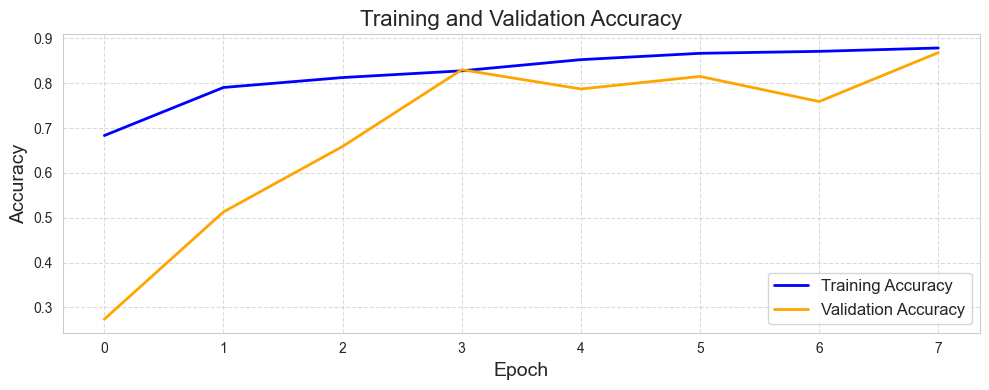

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's whitegrid style
sns.set_style("whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 4))

# Plot training accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy", linewidth=2, color='blue')

# Plot validation accuracy
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2, color='orange')

# Title and labels
plt.title("Training and Validation Accuracy", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Add legend
plt.legend(loc="lower right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

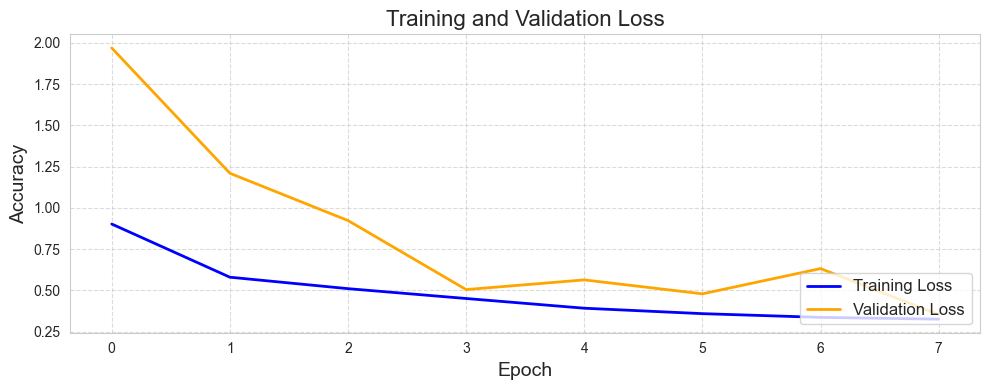

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's whitegrid style
sns.set_style("whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 4))

# Plot training accuracy
plt.plot(history.history["loss"], label="Training Loss", linewidth=2, color='blue')

# Plot validation accuracy
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2, color='orange')

# Title and labels
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Add legend
plt.legend(loc="lower right", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
model.save('hair_model.h5')

/Users/anpreit/anaconda3/envs/ag/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# load model
model = tf.keras.models.load_model('hair_model.h5')

In [29]:
predictions = model.predict(test_images)

32/32 [==============================] - 3s 90ms/step


In [30]:
predictions_final = np.argmax(predictions, axis=1)

In [31]:
test_labels_final = np.argmax(test_labels.values, axis=1)

In [32]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels_final, predictions_final)

print("The Accuracy of the model on the test set is: {}".format(accuracy))

The Accuracy of the model on the test set is: 0.863


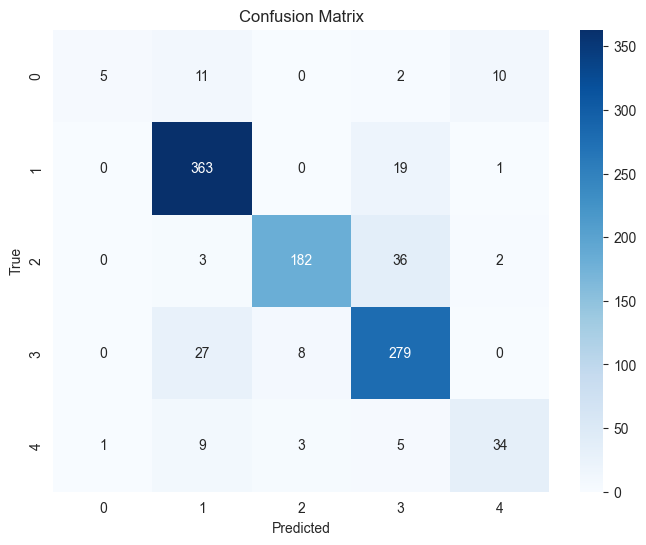

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get unique labels
labels = np.unique(np.concatenate((test_labels_final, predictions_final)))

# Calculate confusion matrix
cm = confusion_matrix(test_labels_final, predictions_final, labels=labels)

# Plot confusion matrix as a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



## Female or Male?

This notebook presents a transfer learning approach using the InceptionV3 architecture pre-trained on the ImageNet dataset for binary image classification. The primary objective is to fine-tune the InceptionV3 model on male/female classification task. The model is trained on a subset of the CelebA dataset, which contains over 200,000 celebrity images with annotations.

#### Transfer Learning with InceptionV3
The base of the model is InceptionV3, a powerful convolutional neural network (CNN) known for its effectiveness in image classification tasks. The pre-trained weights from ImageNet provide a solid foundation for feature extraction. To tailor the model to the current task, only the top layers are modified.

#### Model Architecture
The modified model consists of the InceptionV3 base followed by a global average pooling layer and two densely connected layers. The global average pooling layer reduces the spatial dimensions of the feature maps, while the dense layers perform the final classification. The last layer uses the sigmoid activation function for binary classification.

#### Freezing Layers
To prevent overfitting and retain the knowledge gained during ImageNet pre-training, the initial layers of InceptionV3 are frozen, and only the later layers are trainable during fine-tuning.

#### Compilation
The model is compiled using stochastic gradient descent (SGD) with a low learning rate (lr=0.001) and binary crossentropy as the loss function. The accuracy metric is used to monitor the model's performance.

#### Callbacks
Two callbacks are employed during training: 
- **ModelCheckpoint:** Saves the best model based on the validation accuracy.
- **EarlyStopping:** Halts training if there is no improvement in validation loss after a certain number of epochs, restoring the best weights.



<Axes: xlabel='count', ylabel='Male'>

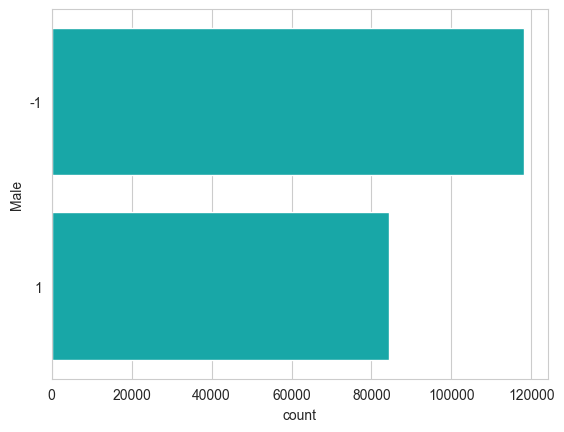

In [34]:
labels = df
features = ['Male']
subset = labels[features + ['image_id']].sample(10000)
import seaborn as sns

sns.countplot(y='Male', data=labels, color="c")


In [35]:
labels = df
features = ['Male']
subset = labels[features + ['image_id']].sample(10000)
image_ids = subset['image_id']
label_data = subset.drop('image_id', axis=1)
label_data = (label_data + 1) // 2
processed_data = pd.concat([image_ids, label_data], axis=1)

processed_data.head()

,image_id,Male
43456,043457.jpg,0
71061,071062.jpg,0
62971,062972.jpg,0
76481,076482.jpg,0
37939,037940.jpg,1


In [36]:
# Load and preprocess images
def load_and_preprocess_image(target_size=(128, 128)):
    images_data = list()
    for idx in range(subset.shape[0]):
        path = "{}/{}".format(str(images_data_path), str(subset.iloc[idx].image_id))
        image = PIL.Image.open(path).resize(target_size)
        image_array = np.asarray(image) / 255
        images_data.append(image_array)
    images_data = np.array(images_data)
    return images_data

In [37]:
images_data = load_and_preprocess_image()
labels = processed_data.drop(['image_id'], axis=1)

In [38]:
# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images_data, labels, test_size=0.2, random_state=42
)

# Split the test dataset into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

In [41]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [42]:
# Freeze layers up to the 100th layer
for layer in base_model.layers[:100]:
    layer.trainable = False

In [43]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create callbacks (optional but recommended)
checkpoint = ModelCheckpoint('inceptionv3_model.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [44]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [67]:
history = model.fit_generator(
    datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) / 32,
    epochs=30,
    validation_data=(val_images, val_labels),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30


/var/folders/9q/_dywz3t10_z2p9yqrdfk41b80000gr/T/ipykernel_73033/422747811.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


250/250 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9581

/Users/anpreit/anaconda3/envs/ag/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 58s 231ms/step - loss: 0.1103 - accuracy: 0.9581 - val_loss: 0.1820 - val_accuracy: 0.9370
Epoch 2/30
250/250 [==============================] - 53s 210ms/step - loss: 0.0988 - accuracy: 0.9610 - val_loss: 0.1846 - val_accuracy: 0.9320
Epoch 3/30
250/250 [==============================] - 54s 215ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.1744 - val_accuracy: 0.9390
Epoch 4/30
250/250 [==============================] - 55s 220ms/step - loss: 0.0906 - accuracy: 0.9663 - val_loss: 0.1681 - val_accuracy: 0.9390
Epoch 5/30
250/250 [==============================] - 55s 219ms/step - loss: 0.0781 - accuracy: 0.9722 - val_loss: 0.1855 - val_accuracy: 0.9400
Epoch 6/30
250/250 [==============================] - 56s 223ms/step - loss: 0.0735 - accuracy: 0.9714 - val_loss: 0.2058 - val_accuracy: 0.9390
Epoch 7/30
250/250 [==============================] - 56s 225ms/step - loss: 0.0711 - accuracy: 0.9725 - val_loss: 0.2021 - val_accuracy: 0.9

In [68]:
model.save('male_model.h5')

In [45]:
model = tf.keras.models.load_model('male_model.h5')

In [46]:
predictions = model.predict(test_images)

32/32 [==============================] - 4s 120ms/step


In [52]:
accuracy = accuracy_score(test_labels, predictions.round())

print("The Accuracy of the model on the test set is: {}".format(accuracy))

The Accuracy of the model on the test set is: 0.944


## High cheekbones model

This model classify the images based on the presence of high cheekbones or not. The model utilizes the MobileNetV2 architecture pre-trained on the ImageNet dataset. The distribution of the two classes is balanced.

#### Transfer Learning with MobileNetV2
The base of the model is MobileNetV2, a lightweight and efficient convolutional neural network (CNN). By leveraging the pre-trained weights from ImageNet, the model benefits from learned features that can be adapted to the high cheekbones classification task.

#### Model Architecture
The model architecture consists of the MobileNetV2 base followed by a global average pooling layer, a dense layer with ReLU activation, dropout regularization for generalization, and a final dense layer with a sigmoid activation function for binary classification.

#### Data Augmentation
To enhance model robustness and improve generalization, data augmentation techniques are applied during training. These include random rotation, width and height shifts, shear, zoom, and horizontal flipping.


In [53]:
from keras.applications import MobileNetV2

In [54]:
# Assuming df is your dataframe with labels
labels = df
features = ['High_Cheekbones']
subset = labels[features + ['image_id']].sample(10000)

In [55]:
image_ids = subset['image_id']
label_data = subset.drop('image_id', axis=1)

# Convert labels from -1/1 to 0/1
label_data = (label_data + 1) // 2

# Reattach the image_id column
processed_data = pd.concat([image_ids, label_data], axis=1)

processed_data.head()


,image_id,High_Cheekbones
69407,069408.jpg,0
186792,186793.jpg,0
93514,093515.jpg,1
83652,083653.jpg,0
181701,181702.jpg,0


In [56]:
# count how many people have high cheekbones
label_data['High_Cheekbones'].value_counts()

High_Cheekbones
0    5443
1    4557
Name: count, dtype: int64

In [57]:
def load_and_preprocess_image(target_size=(128, 128)):
    images_data = list()
    for idx in range(subset.shape[0]):
        path = "{}/{}".format(str(images_data_path), str(subset.iloc[idx].image_id))
        image = PIL.Image.open(path).resize(target_size)
        image_array = np.asarray(image) / 255
        images_data.append(image_array)
    images_data = np.array(images_data)
    return images_data

In [58]:
images_data = load_and_preprocess_image()
labels = processed_data.drop(['image_id'], axis=1)


# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images_data, labels, test_size=0.2, random_state=42
)

# Split the test dataset into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)


In [213]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [225]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create callbacks (optional but recommended)
checkpoint = ModelCheckpoint('inceptionv3_model.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model.fit_generator(
    datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) / 32,
    epochs=30,
    validation_data=(val_images, val_labels),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30


/var/folders/9q/_dywz3t10_z2p9yqrdfk41b80000gr/T/ipykernel_73033/2417424179.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


250/250 [==============================] - 26s 96ms/step - loss: 0.2605 - accuracy: 0.8859 - val_loss: 0.4456 - val_accuracy: 0.8510
Epoch 2/30


/Users/anpreit/anaconda3/envs/ag/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 23s 91ms/step - loss: 0.2341 - accuracy: 0.8966 - val_loss: 0.5520 - val_accuracy: 0.8430
Epoch 3/30
250/250 [==============================] - 23s 91ms/step - loss: 0.2208 - accuracy: 0.9031 - val_loss: 0.5812 - val_accuracy: 0.8370
Epoch 4/30
250/250 [==============================] - 23s 90ms/step - loss: 0.2116 - accuracy: 0.9169 - val_loss: 0.7814 - val_accuracy: 0.7980
Epoch 5/30
250/250 [==============================] - 22s 90ms/step - loss: 0.2099 - accuracy: 0.9137 - val_loss: 0.5121 - val_accuracy: 0.8360
Epoch 6/30
250/250 [==============================] - 23s 92ms/step - loss: 0.2045 - accuracy: 0.9156 - val_loss: 0.5385 - val_accuracy: 0.8330
Epoch 7/30
250/250 [==============================] - 22s 89ms/step - loss: 0.1947 - accuracy: 0.9209 - val_loss: 0.5350 - val_accuracy: 0.8270
Epoch 8/30
250/250 [==============================] - 23s 90ms/step - loss: 0.1910 - accuracy: 0.9200 - val_loss: 0.5317 - val_accuracy: 0.8390
Epo

In [226]:
model.save('cheekbone_model.h5')

In [59]:
model = tf.keras.models.load_model('cheekbone_model.h5')

In [61]:
predictions = model.predict(test_images)
accuracy = accuracy_score(test_labels, predictions.round())

32/32 [==============================] - 2s 63ms/step


In [62]:
print("The Accuracy of the model on the test set is: {}".format(accuracy))

The Accuracy of the model on the test set is: 0.852
